In [1]:
import pandas as pd
import numpy as np
import os, re, sys, csv
from collections import defaultdict
from tqdm import tqdm

In [2]:
import pickle as pkl
import argparse
import collections

import tree
import torch
import models
import data_utils
import train_helper

import numpy as np

from tqdm import tqdm

In [3]:
test_pairs = []

with open('../data/bible/paraphrase/test_x.txt', 'r') as f:
    for line in f:
        line = eval(line.strip())
        
        assert len(line) == 2
        
        test_pairs.append(line)
        #print(line[0], line[1], sep='\t', file=write_file)

In [4]:
test_labels = []

with open('../data/bible/paraphrase/test_y.txt', 'r') as f:
    for line in f:
        line = eval(line.strip())
        
        test_labels.append(line)

In [5]:
test_pairs[0]

['I have not turned aside from thine ordinances; For thou hast taught me.',
 'I have not turned aside from your ordinances, for you have taught me.']

In [6]:
test_labels[0]

['ASV', 'WEB']

In [6]:
#get vectors 

In [7]:
#and reconstruction loss

In [7]:
save_file = "./vgvae-lstm-bible/bible_lstm_/bible_lstm_best.ckpt"

In [8]:
#load model
save_dict = torch.load(
    save_file,
    map_location=lambda storage,
    loc: storage)

In [9]:
config = save_dict['config']
checkpoint = save_dict['state_dict']
config.debug = True

In [10]:
vocab_file = './bible-vocab/vocab_50000'

In [11]:
with open(vocab_file, "rb") as fp:
    W, vocab = pkl.load(fp)

In [12]:
#vocab

In [13]:
id2vocab = {i:v for v, i in vocab.items()}

In [14]:
with train_helper.experiment(config, config.save_prefix) as e:
    e.log.info("vocab loaded from: {}".format(vocab_file))
    model = models.vgvae(
        vocab_size=len(vocab),
        embed_dim=e.config.edim if W is None else W.shape[1],
        embed_init=W,
        experiment=e)
    model.eval()
    model.load(checkpointed_state_dict=checkpoint)
    e.log.info(model)

10-14 11:27 INFO: vocab loaded from: ./bible-vocab/vocab_50000
10-14 11:27 INFO: transferred model to gpu
10-14 11:27 INFO: model loaded!
10-14 11:27 INFO: vgvae(
  (yencode): bilstm(
    (embed): Embedding(50003, 50)
    (lstm): LSTM(50, 50, batch_first=True, bidirectional=True)
  )
  (zencode): bilstm(
    (embed): Embedding(50003, 50)
    (lstm): LSTM(50, 50, batch_first=True, bidirectional=True)
  )
  (mean1): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=100, out_features=50, bias=True)
  )
  (logvar1): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=100, out_features=1, bias=True)
  )
  (mean2): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=100, out_featu

In [15]:
def encode(d):
    global vocab, batch_size
    new_d = [[vocab.get(w, 0) for w in s.split(" ")] for s in d]
    all_y_vecs = []
    all_z_vecs = []

    for s1, m1, s2, m2, _, _, _, _, \
            _, _, _, _, _, _, _, _, _ in \
            tqdm(data_utils.minibatcher(
                data1=np.array(new_d),
                data2=np.array(new_d),
                batch_size=100,
                score_func=None,
                shuffle=False,
                mega_batch=0,
                p_scramble=0.)):
            s1, m1, s2, m2 = \
                model.to_vars(s1, m1, s2, m2)
            _, yvecs = model.yencode(s1, m1)
            _, zvecs = model.zencode(s2, m2)

            ymean = model.mean1(yvecs)
            ymean = ymean / ymean.norm(dim=-1, keepdim=True)
            zmean = model.mean2(zvecs)

            all_y_vecs.append(ymean.cpu().data.numpy())
            all_z_vecs.append(zmean.cpu().data.numpy())
    return np.concatenate(all_y_vecs), np.concatenate(all_z_vecs)

In [17]:
pairs_1 = [test_pairs[i][0] for i in range(len(test_pairs))]

In [18]:
pairs_2 = [test_pairs[i][1] for i in range(len(test_pairs))]

In [19]:
pairs_1[100], pairs_2[100]

('This book of the law shall not depart out of thy mouth; but thou shalt meditate therein day and night, that thou mayest observe to do according to all that is written therein: for then thou shalt make thy way prosperous, and then thou shalt have good success.',
 'This book of the law shall not depart from thy mouth; and thou shalt meditate upon it day and night, that thou mayest take heed to do according to all that is written therein; for then shalt thou have good success in thy ways, and then shalt thou prosper.')

In [20]:
labels_0 = [test_labels[i][0] for i in range(len(test_labels))]
labels_1 = [test_labels[i][1] for i in range(len(test_labels))]

In [28]:
#y_vecs, z_vecs = encode(pairs_1)

In [29]:
#y_vecs.shape, z_vecs.shape

In [30]:
#len(test_pairs)

In [31]:
#y_vecs_1, z_vecs_1 = y_vecs, z_vecs

In [32]:
#y_vecs_2, z_vecs_2 = encode(pairs_2)

In [33]:
#y_vecs_2.shape, z_vecs_2.shape

In [34]:
#pkl.dump([y_vecs_1, z_vecs_1], open('./vgvae-bow-bible/bible_bow_/test_vecs_1.pkl', 'wb'))

In [35]:
#pkl.dump([y_vecs_2, z_vecs_2], open('./vgvae-bow-bible/bible_bow_/test_vecs_2.pkl', 'wb'))

### Encode test sentences

In [21]:
all_test_sentences = pairs_1 + pairs_2

In [22]:
len(all_test_sentences)

261208

In [23]:
all_labels = labels_0 + labels_1

In [24]:
all_labels[:10]

['ASV', 'ASV', 'ASV', 'ASV', 'KJV', 'DRA', 'ASV', 'KJV', 'DRA', 'BBE']

In [25]:
test_stats = train_helper.tracker(["loss", "vmf_kl", "gauss_kl",
                                        "rec_logloss", "para_logloss",
                                        "wploss", "dp_loss"])

In [26]:
epoch = 0

In [27]:
y_vecs, z_vecs = encode(all_test_sentences)

/pkgs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # Remove the CWD from sys.path while we load stuff.
/pkgs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()
100%|██████████| 2613/2613 [00:49<00:00, 53.21it/s]


In [36]:
y_vecs.shape, z_vecs.shape

((261208, 50), (261208, 50))

In [37]:
pkl.dump(y_vecs, open('vgvae-lstm-bible/bible_lstm_/test_y_vecs.pkl', 'wb'))
pkl.dump(z_vecs, open('vgvae-lstm-bible/bible_lstm_/test_z_vecs.pkl', 'wb'))

In [38]:
generated_sentences = []

In [39]:
test_stats = train_helper.tracker(["loss", "vmf_kl", "gauss_kl",
                                        "rec_logloss", "para_logloss",
                                        "wploss", "dp_loss"])

In [40]:
def get_loss(d):
    global vocab, batch_size
    new_d = [[vocab.get(w, 0) for w in s.split(" ")] for s in d]
    #all_y_vecs = []
    #all_z_vecs = []

    for s1, m1, s2, m2, t1, tm1, t2, tm2, \
                 n1, nm1, nt1, ntm1, n2, nm2, nt2, ntm2, _ in \
            tqdm(data_utils.bow_minibatcher(
                data1=np.array(new_d),
                data2=np.array(new_d),
                batch_size=100,
                vocab_size = len(vocab),
                score_func=model.score,
                shuffle=False,
                mega_batch=0,
                p_scramble=0.)):
#             s1, m1, s2, m2 = \
#                 model.to_vars(s1, m1, s2, m2)
            s1, m1, s2, m2, t1, tm1, t2, tm2, \
                 n1, nm1, nt1, ntm1, n2, nm2, nt2, ntm2 = model.to_vars(s1, m1, s2, m2, t1, tm1, t2, tm2,
                 n1, nm1, nt1, ntm1, n2, nm2, nt2, ntm2)
            
            loss, vkl, gkl, rec_logloss, para_logloss, wploss, dploss = \
                model(s1, m1, s2, m2, t1, tm1, t2, tm2,
                      n1, nm1, nt1, ntm1, n2, nm2, nt2, ntm2,
                      e.config.vmkl, e.config.gmkl,
                      epoch > 1 and e.config.dratio and e.config.mb > 1)
#             _, yvecs = model.yencode(s1, m1)
#             _, zvecs = model.zencode(s2, m2)

#             ymean = model.mean1(yvecs)
#             ymean = ymean / ymean.norm(dim=-1, keepdim=True)
#             zmean = model.mean2(zvecs)

#             all_y_vecs.append(ymean.cpu().data.numpy())
#             all_z_vecs.append(zmean.cpu().data.numpy())
            test_stats.update(
                {"loss": loss, "vmf_kl": vkl, "gauss_kl": gkl,
                 "para_logloss": para_logloss, "rec_logloss": rec_logloss,
                 "wploss": wploss, "dp_loss": dploss},
                len(s1))
    #return np.concatenate(all_y_vecs), np.concatenate(all_z_vecs)
    return test_stats

In [69]:
test_stats = get_loss(all_test_sentences)

/pkgs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # Remove the CWD from sys.path while we load stuff.
/pkgs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()
  0%|          | 0/2613 [00:00<?, ?it/s]


RuntimeError: Sizes of tensors must match except in dimension 1. Got 50003 and 54

In [44]:
#pkl.dump(test_stats, open('./vgvae-bow-bible/bible_bow_/test_stats.pkl', 'wb'))

In [23]:
#test_vecs_1 = pkl.load(open('./vgvae-bow-bible/bible_bow_/test_vecs_1.pkl', 'rb'))

In [24]:
#test_vecs_2 = pkl.load(open('./vgvae-bow-bible/bible_bow_/test_vecs_2.pkl', 'rb'))

In [25]:
#len(test_vecs_1)

2

In [26]:
# y_vecs = []
# z_vecs = []

# for y, z in zip(test_vecs_1[0], test_vecs_1[1]):
#     y_vecs.append(y)
#     z_vecs.append(z)

In [27]:
# for y, z in zip(test_vecs_2[0], test_vecs_1[1]):
#     y_vecs.append(y)
#     z_vecs.append(z)

In [44]:
# y_vecs = np.array(y_vecs)
# z_vecs = np.array(z_vecs)

In [45]:
y_vecs.shape, z_vecs.shape

((261208, 50), (261208, 50))

In [33]:
len(all_labels)

261208

# Generation

In [46]:
test_d = all_test_sentences[:20]

In [47]:
new_d = [[vocab.get(w, 0) for w in s.split(" ")] for s in test_d]

In [48]:
unit_batcher = data_utils.minibatcher(
                data1=np.array(new_d),
                data2=np.array(new_d),
                batch_size=1,
                vocab_size = len(vocab),
                score_func=model.score,
                shuffle=False,
                mega_batch=0,
                p_scramble=0.)

/pkgs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/pkgs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


In [49]:
s1, m1, s2, m2, t1, tm1, t2, tm2, \
                 n1, nm1, nt1, ntm1, n2, nm2, nt2, ntm2, _ = next(unit_batcher)

In [50]:
test_d[0]

'I have not turned aside from thine ordinances; For thou hast taught me.'

In [51]:
s1.shape

(1, 13)

In [52]:
s2.shape

(1, 13)

In [53]:
s1, m1, s2, m2, t1, tm1, t2, tm2, \
                 n1, nm1, nt1, ntm1, n2, nm2, nt2, ntm2 = model.to_vars(s1, m1, s2, m2, t1, tm1, t2, tm2,
                 n1, nm1, nt1, ntm1, n2, nm2, nt2, ntm2)

In [54]:
t1.shape

torch.Size([1, 15])

In [55]:
y_vecs[0].reshape(1, -1).shape

(1, 50)

In [56]:
model.decode.hid2vocab

Sequential(
  (0): Linear(in_features=100, out_features=50, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.0, inplace=False)
  (3): Linear(in_features=50, out_features=50003, bias=True)
)

In [57]:
import torch.nn.functional as F

In [58]:
bs, sl = tm1.size()

In [59]:
bs, sl

(1, 15)

In [62]:
yvec = torch.Tensor(y_vecs[0].reshape(-1,1)).cuda()
type(yvec)

torch.Tensor

In [63]:
zvec = torch.Tensor(z_vecs[0].reshape(-1,1)).cuda()
type(zvec)

torch.Tensor

In [72]:
yvec.shape, zvec.shape

(torch.Size([50, 1]), torch.Size([50, 1]))

In [75]:
#zvec.unsqueeze(0).shape

torch.Size([1, 50, 1])

In [78]:
ex_input_vecs = zvec.unsqueeze(1).expand(-1, sl, -1)
ex_output_vecs = yvec.unsqueeze(1).expand(-1, sl, -1)

In [80]:
ex_input_vecs = ex_input_vecs.reshape(bs, sl, -1)

In [81]:
ex_output_vecs = ex_output_vecs.reshape(bs, sl, -1)

In [82]:
ex_input_vecs.shape, ex_output_vecs.shape

(torch.Size([1, 15, 50]), torch.Size([1, 15, 50]))

In [67]:
import model_utils

In [70]:
tm1.shape

torch.Size([1, 15])

In [83]:
ori_output_seq, _ = model_utils.get_rnn_vecs(
            ex_input_vecs, tm1, model.decode.cell)

In [84]:
ori_output_seq.shape

torch.Size([1, 15, 50])

In [85]:
output_seq = torch.cat([ori_output_seq, ex_output_vecs], -1)

In [86]:
output_seq.shape

torch.Size([1, 15, 100])

In [100]:
pred = model.decode.hid2vocab(output_seq)[:, :-1, :]

In [101]:
pred.shape

torch.Size([1, 14, 50003])

In [102]:
logits = F.log_softmax(pred,-1)

In [103]:
logits.shape

torch.Size([1, 14, 50003])

In [90]:
t1.shape

torch.Size([1, 15])

In [91]:
type(pred)

torch.Tensor

In [93]:
pred = pred.detach().cpu().numpy()

In [94]:
pred.shape

(1, 14, 50003)

In [96]:
pred[0][0].shape

(50003,)

In [105]:
logits = logits.detach().cpu().numpy()
np.sum(logits[0][0])

-11637530.0

In [106]:
for row in logits[0]:
    argmax = np.argmax(row)
    word = id2vocab[argmax]
    print(word)

now,
pharisees,
disciples,
will
a
womb.
member,
most
north.
behind:
doves.
were.
mine
place,


In [57]:
def generate(model, sem_vec, syn_vec, tgt, tgt_mask):
    input_vecs = torch.cat([sem_vec, syn_vec], -1)
    print(input_vecs.shape)
    logits = F.log_softmax(model.decode.hid2vocab(input_vecs), -1)
    return logits

In [59]:
logits = generate(model, torch.Tensor(y_vecs[0].reshape(1,-1)).cuda(), torch.Tensor(z_vecs[0].reshape(1,-1)).cuda(), t1, tm1)

torch.Size([1, 100])


In [60]:
logits.shape

torch.Size([1, 50003])

In [63]:
tm1[0].shape

torch.Size([50003])

In [67]:
type(tm1.cpu().numpy())

numpy.ndarray

In [69]:
np.sum(tm1.cpu().numpy()[0])

13.0

In [71]:
#argmax of these many in logits
type(logits)

torch.Tensor

In [73]:
logits = logits.detach().cpu().numpy()

In [74]:
logits.shape

(1, 50003)

In [75]:
args = np.argsort(logits[0])[::-1]

In [76]:
args[:10]

array([ 3,  4,  5,  6,  7,  8, 10, 11,  9, 12])

In [82]:
for a in args[:13]:
    print(id2vocab[a])

the
and
of
to
in
he
a
for
that
i
his
they
with


In [83]:
for ind, val in enumerate(tm1.cpu().numpy()[0]):
    if val == 1:
        print(id2vocab[ind])

not
have
from
thou
hast
me.
thine
turned
aside
taught
ordinances;


In [84]:
test_d[0]

'I have not turned aside from thine ordinances; For thou hast taught me.'

In [32]:
#categorize
versions = list(set(all_labels))
label_map = {v: i for i,v in enumerate(versions)}
test_y = [label_map[x] for x in all_labels]

In [33]:
label_map

{'DRA': 0,
 'LEB': 1,
 'KJV': 2,
 'BBE': 3,
 'YLT': 4,
 'WEB': 5,
 'ASV': 6,
 'DARBY': 7}

In [35]:
test_y[:5]

[6, 6, 6, 6, 2]

In [26]:
#classify
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [27]:
from sklearn.model_selection import cross_val_score

In [36]:
clf = LogisticRegression()
scores = cross_val_score(clf, y_vecs, test_y, cv=5)
    
    

/h/vkpriya/condaenvs/pyt_cu/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/h/vkpriya/condaenvs/pyt_cu/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_L

In [37]:
len(scores)

5

In [38]:
for split in scores:
    print(np.mean(split), np.std(split))

0.2332223115500938 0.0
0.2356150223957735 0.0
0.23278205275448874 0.0
0.2325950881491549 0.0
0.2314848490649107 0.0


In [39]:
clf = LogisticRegression()
scores = cross_val_score(clf, z_vecs, test_y, cv=5)

/h/vkpriya/condaenvs/pyt_cu/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/h/vkpriya/condaenvs/pyt_cu/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_L

In [40]:
for split in scores:
    print(np.mean(split), np.std(split))

0.18448757704528923 0.0
0.1880670724704261 0.0
0.17045672064622336 0.0
0.15053310618096896 0.0
0.12551444267912176 0.0


In [43]:
plot_y_vecs = []
plot_z_vecs = []
plot_labels = []

label_indices = defaultdict(list)

for i, l in enumerate(all_labels):
    label_indices[l].append(i)
    

In [42]:
import random

In [44]:
for l, inds in label_indices.items():
    cur_inds = random.sample(inds, k=50)
    
    plot_y_vecs.extend([y_vecs[i] for i in cur_inds])
    plot_z_vecs.extend([z_vecs[i] for i in cur_inds])
    plot_labels.extend([l for i in cur_inds])

In [45]:
len(plot_labels), len(plot_y_vecs), len(plot_z_vecs)

(400, 400, 400)

In [54]:
plot_labels[:5]

['ASV', 'ASV', 'ASV', 'ASV', 'ASV']

In [46]:
#plot z
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt

In [47]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(plot_y_vecs)



[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.001s...
[t-SNE] Computed neighbors for 400 samples in 0.026s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 0.100615
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.347511
[t-SNE] KL divergence after 300 iterations: 1.494590


In [48]:
tsne_results.shape

(400, 2)

In [50]:
import matplotlib.cm as cm

In [52]:
colors = cm.rainbow(np.linspace(0, 1, len(versions)))

In [53]:
colors

array([[5.00000000e-01, 0.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [2.17647059e-01, 4.29120609e-01, 9.75511968e-01, 1.00000000e+00],
       [7.25490196e-02, 7.82927610e-01, 9.00586702e-01, 1.00000000e+00],
       [3.54901961e-01, 9.74138602e-01, 7.82927610e-01, 1.00000000e+00],
       [6.45098039e-01, 9.74138602e-01, 6.22112817e-01, 1.00000000e+00],
       [9.27450980e-01, 7.82927610e-01, 4.34676422e-01, 1.00000000e+00],
       [1.00000000e+00, 4.29120609e-01, 2.19946358e-01, 1.00000000e+00],
       [1.00000000e+00, 1.22464680e-16, 6.12323400e-17, 1.00000000e+00]])

In [55]:
color_map = [colors[label_map[i]] for i in plot_labels]

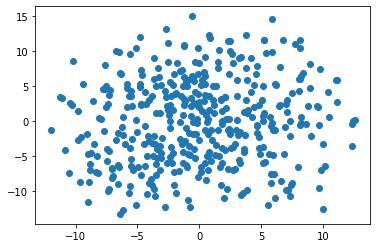

In [56]:
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], cmap=color_map)

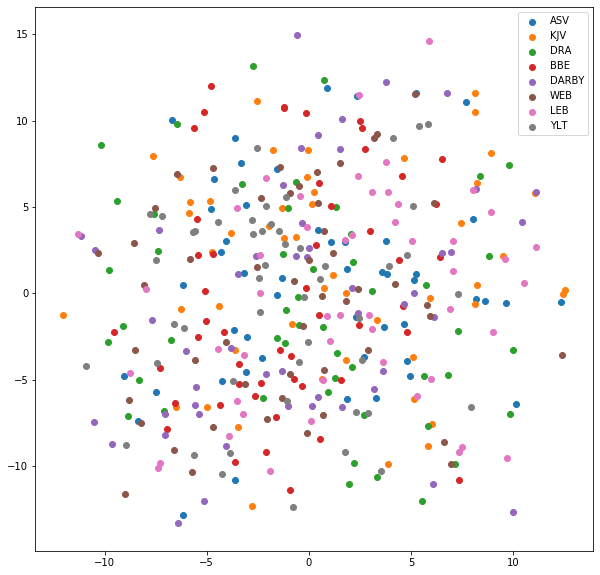

In [58]:
plt.figure(figsize=(10,10))
for i in range(0, len(plot_y_vecs), 50):
    plt.scatter(tsne_results[:, 0][i:i+50], tsne_results[:, 1][i:i+50], label = plot_labels[i])
plt.legend()

In [59]:
#z
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(plot_z_vecs)



[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.002s...
[t-SNE] Computed neighbors for 400 samples in 0.025s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 0.311228
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.742897
[t-SNE] KL divergence after 300 iterations: 0.623622


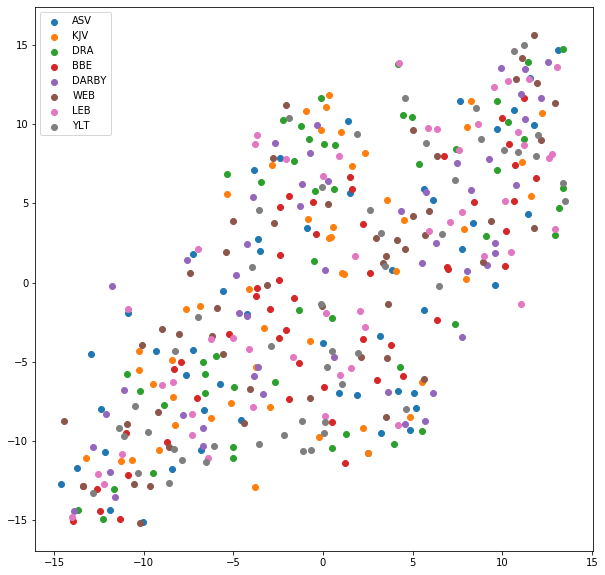

In [60]:
plt.figure(figsize=(10,10))
for i in range(0, len(plot_z_vecs), 50):
    plt.scatter(tsne_results[:, 0][i:i+50], tsne_results[:, 1][i:i+50], label = plot_labels[i])
plt.legend()

In [ ]:
#z
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(z_vecs)



[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 261208 samples in 3.600s...


In [ ]:
plt.figure(figsize=(10,10))
for i in range(len(z_vecs)):
    plt.scatter(tsne_results[:, 0][i], tsne_results[:, 1][i], label=all_labels[i])
plt.legend()

# Generation